# Moist Thermodynamics

In [4]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import pathlib as path
import numpy as np 
from scipy.integrate import odeint

In [5]:
# Useful constants which come up often. All given in SI units, any conversion must be done in place
K_b = 1.3806*10**(-23)  # Boltzmann's constant, J / K
Mu = 1.6605*10**(-27)   # Atomic Mass unit, kg
R = K_b / Mu      # Molar gas constant, J / (K*kg) = (m/s)^2 * K
Mol = 1 / Mu      # This definition seems inconsisent at times, some resorces define a mol as 10**23 molecules, and some say 10**26. They should elaborate; 
                  # gram mol is 10**23, and mol is 10**26. 
P_surface = 10**5
T_0 = 273.15      # Kelvin vs Degrees offset
# Earth 
g = 9.81        # m/s^2
R_over_Cp = 2/7 # For diatomic gasses (dimensionless)
R_e = 6.3716    # m

# Dry earth air params
N2_conc = 0.78084 
O2_conc = 0.20947
Ar_conc = 0.00934
N2_mass = 28 # kg / mol
O2_mass = 32 # kg / mol
Ar_mass = 40 # kg / mol
Dry_Air_Mass = (N2_conc * N2_mass) + (O2_conc * O2_mass) + (Ar_conc * Ar_mass) #kg / mol 
Dry_Air_Gas_Constant = R / Dry_Air_Mass 

## The Clausius Clapeyron Equation

$\frac{{dP}}{{dT}} = \frac{{L}}{{T \cdot (\Delta V_{vap} - \Delta V_{liq})}}$


In [6]:
# We define a CC function which can tell us the saturation vapour pressure of water. Reference points are using actual data
RefT = 300 
RefP = 3800
L   = 2.5 * 10**6 # This function assumes a constant L with temperature, even below the T at which vapour to solid is the preffered transition 
R_a = 8314 / 18
def Saturation_VP(T):
    var = RefP * np.exp(-((L/(R_a)) * ((1/T) - (1/RefT))))
    #return f'The saturation vapour pressure at T = {T}K is roughly {var}'
    return var

Text(0, 0.5, 'Pressure [Pa]')

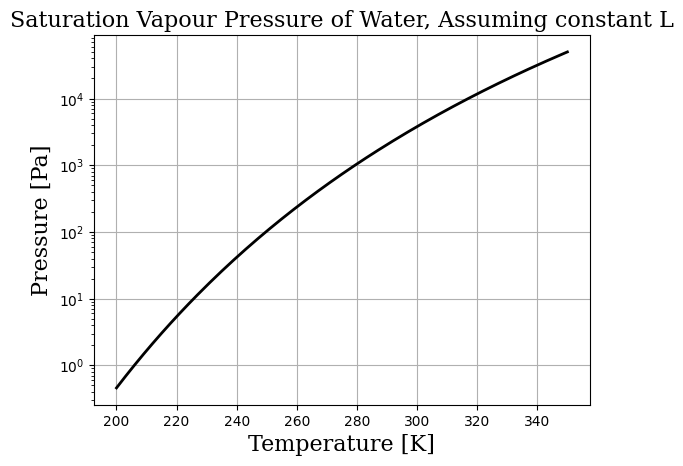

In [7]:
Ts = np.linspace(200, 350, 151)
Psats = Saturation_VP(Ts)
plt.plot(Ts, Psats, color = 'black', linewidth = 2)
plt.yscale('log')
plt.grid()
plt.title('Saturation Vapour Pressure of Water, Assuming constant L', font = 'serif', fontsize = 16)
plt.xlabel('Temperature [K]', font = 'serif', fontsize = 16)
plt.ylabel('Pressure [Pa]', font = 'serif', fontsize = 16)

Note that our assumption of constant L is pretty bad, particularly in the region where the preffered phase transition is vapour $\rightarrow$ solid. Even in vapour $\rightarrow$ liquid transitions, L runs with T and this should be accounted for. Hence, confidence should be reduced in outputs of this simple function far away from where it takes the actual value recovered in formula tables, of [p = 3800Pa, T = 300K]

## Pure Condensible Component Atmospheres

In the case of a single component atmosphere, in equilibrium with a reservoir of condensed substance at the surface, the temperature profile will follow that of the saturated moist adiabat. This goes as the inverse of the above function. 
$$
T(p) = \frac{T_0}{1 - \frac{RT}{L}Ln(\frac{P}{P_{sat}(T_0)})}
$$
Surface temperature will fix when on this plot you begin to follow the saturated moist adiabat. For any given surface T, the pressure will adjust accordingly, either by more condensible substance evaporating out of the `ocean', or by condensate leaving the atmosphere. 

In [8]:
def SaturatedMoistAtmosphere(T_0, P):
    Ps = Saturation_VP(T_0)
    return T_0 / ( 1 - (R*T_0/(18*L))*np.log(P/Ps))

Text(0, 0.5, 'Pressure [Pa]')

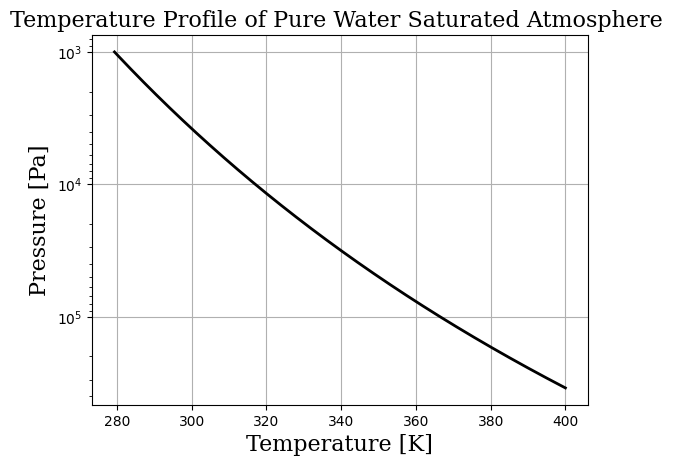

In [9]:
# Lets say we start on an atmosphere with surface temperature 500K, and pressure determined by CC.
T_naught = 400
P = np.linspace(Saturation_VP(T_naught), 1000, 5000)
Ts = SaturatedMoistAtmosphere(T_naught, P)
plt.plot(Ts, P, color = 'black', linewidth = 2)
plt.gca().invert_yaxis()
plt.yscale('log')
plt.grid()
plt.title('Temperature Profile of Pure Water Saturated Atmosphere ', font = 'serif', fontsize = 16)
plt.xlabel('Temperature [K]', font = 'serif', fontsize = 16)
plt.ylabel('Pressure [Pa]', font = 'serif', fontsize = 16)

What if water could not condense for some reason? Then we follow along the dry adiabat in this case. See below.  

Text(0, 0.5, 'Pressure [Pa]')

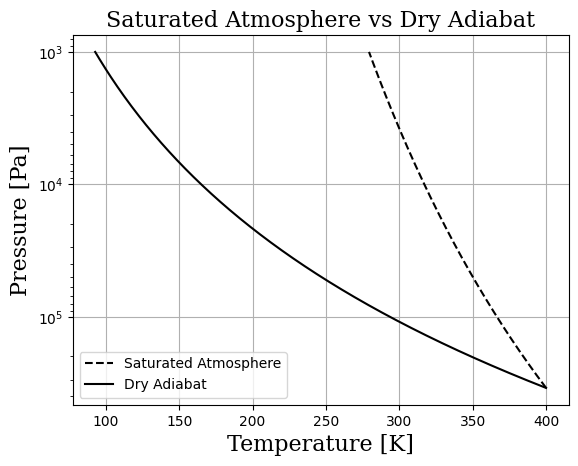

In [10]:
def DryAdiabatConstantC(Surface_P, Surface_T, P, R_over_C_p):
    return Surface_T * (P / Surface_P)**(R_over_C_p)
T_dry = DryAdiabatConstantC(Surface_P = P[0], Surface_T = T_naught, P = P, R_over_C_p = 8314 / (18*1847))
plt.plot(Ts, P, label = 'Saturated Atmosphere', color = 'black', linestyle = '--')
plt.plot(T_dry, P, label = 'Dry Adiabat', color = 'black')
plt.legend()
plt.yscale('log')
plt.gca().invert_yaxis()
plt.grid()
plt.title('Saturated Atmosphere vs Dry Adiabat', font = 'serif', fontsize = 16)
plt.xlabel('Temperature [K]', font = 'serif', fontsize = 16)
plt.ylabel('Pressure [Pa]', font = 'serif', fontsize = 16)

Hence, the ability of a gas to condense in an atmosphere has the effect of making the atmosphere warmer at every point. Lets consider the case where the conditions at the surface are such that the dry adiabat is followed. In a single component atmosphere, this is the case when there is no reservoir of condensate to reach equilibrium with. E.g., the moist adiabat exists as is, and we follow the dry adiabat until saturation is reached and then condensate leaves the parcel, warming it up so that it follows the dry adiabat. 

Text(0, 0.5, 'Pressure [Pa]')

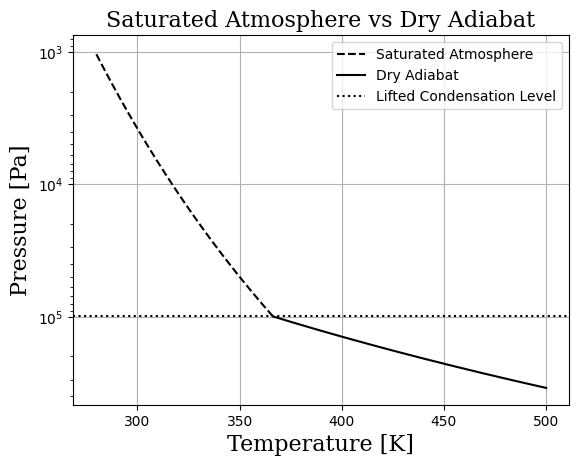

In [11]:
def DryAdiabatConstantC(Surface_P, Surface_T, P, R_over_C_p):
    return Surface_T * (P / Surface_P)**(R_over_C_p)
    
T_dry = DryAdiabatConstantC(Surface_P = P[0], Surface_T = T_naught+100, P = P, R_over_C_p = 8314 / (18*1847))

intersection_T = None
intersection_P = None
for i in range(len(Ts)):
    if np.isclose(Ts[i], T_dry[i], atol=0.05):  # Adjust tolerance as needed
        intersection_T = Ts[i]
        intersection_P = P[i]

newTsat = [value for value in Ts if value < intersection_T]
newPsat = [value for value in P if value < intersection_P]

newTadiabat = [value for value in T_dry if value > intersection_T]
newPadiabat = [value for value in P if value > intersection_P]

plt.plot(newTsat, newPsat, label = 'Saturated Atmosphere', color = 'black', linestyle = '--')
plt.plot(newTadiabat, newPadiabat, label = 'Dry Adiabat', color = 'black')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.grid()
plt.axhline(intersection_P, label = 'Lifted Condensation Level', linestyle = 'dotted', color = 'black')
plt.legend()
plt.title('Saturated Atmosphere vs Dry Adiabat', font = 'serif', fontsize = 16)
plt.xlabel('Temperature [K]', font = 'serif', fontsize = 16)
plt.ylabel('Pressure [Pa]', font = 'serif', fontsize = 16)

In this case, a parcel of air will initially rise up along the dry adiabat, until supersaturation where the lines intersect. This point is called the lifted condensation level. This is the altitude where you would see visible clouds.

## Mixtures of Condensibile and Non-Condensible Atmospheres

We can define a moist adiabat for a mixture of two gasses. This starts with the assumption that the atmosphere is at saturation at all points, and lifting will cause condensation. Lets do this for earth, and try and match up to some atmospheric sounding data. We will do this for the case that the partial pressure of the non condensing substance is approximately the atmospheric pressure. 

### Dry vs Moist Adiabats

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
mc = 18 # H2O
ma = 29 # Air
Ra = R/ma
Rc = R/mc
c_pa = 1000
L = 2.4965e6 # @ 273 K
Tstar = 273 # @ 273 K
pstar = 612 # @ 273 K

In [19]:
def get_log_slope(q,T):
    return (Ra/c_pa)*( ( 1+((L*q)/(Ra*T)) )/ ( 1 + ((q*L**2)/(c_pa*Rc*T**2)) ) )
def get_q(psat,p):
    return (mc*psat)/(ma*p)
def get_psat(T):
    return pstar*np.exp((L/Rc)*(1/Tstar - 1/T))
R = 8314

In [15]:
def F(T,p):
    psat = get_psat(T)
    q = get_q(psat,p)
    return ((Ra*T)/(c_pa*p))*( ( 1 + (L*q)/(Ra*T) ) / ( 1 + (q*L**2)/(c_pa*Rc*T**2) ) )
T0 = 305
p0 = 1e5
p = np.exp(np.linspace(np.log(1e5),np.log(1),10000))
def ad_T(p):
    return T0*(p/p0)**(Ra/c_pa)

In [16]:
solution = odeint(F,T0,p)

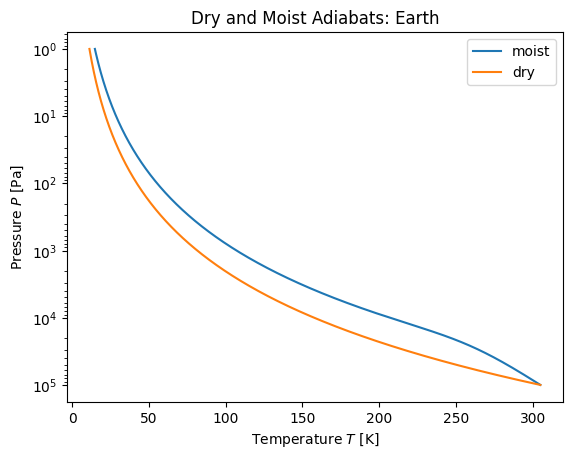

In [17]:
plt.plot(solution,p, label="moist")
plt.plot(ad_T(p),p, label="dry")
plt.yscale('log')
plt.gca().invert_yaxis()
plt.title("Dry and Moist Adiabats: Earth")
plt.xlabel("Temperature $T$ [K]")
plt.ylabel("Pressure $P$ [Pa]")
plt.legend()